这是GPU计算SPEI的验证性质脚本

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb
import torch
import xarray as xr
import dask as dk
import multiprocessing as mp
import os
import rasterio as rio
import rioxarray as rxr
import time
from numpy import inf
import lmoments3 as lm
from lmoments3 import distr

检测CUDA状态并设置默认设备

In [2]:
if torch.cuda.is_available():
    torch.set_default_device('cuda')
else:
    torch.set_default_device('cpu')

读入示例数据

In [3]:

def read_precip():
    data_frame_list = []    
    for i in os.listdir(os.path.join("..","..","..","scripts/outputs/PRECIP")):
        filename  = os.path.join("..","..","..","scripts/outputs/PRECIP",i)
        data_frame = xr.open_dataset(filename,decode_coords="all").to_array()[0,:,:,:]
        data_frame_list.append(data_frame)
    return np.concatenate(data_frame_list,axis=0)

def read_pet():
    data_frame_list = []
    for i in os.listdir(os.path.join("..","..","..","scripts","outputs","PET")):
        data_frame_list.append(xr.open_dataset(os.path.join("..","..","..","scripts","outputs","PET",i),decode_coords="all").to_array())
    return np.concatenate(data_frame_list,axis=0)

In [4]:
pre_frame = read_precip()[0:192,:,:]*0.1
pet_frame = read_pet()

In [5]:
print(pre_frame.shape)
print(pet_frame.shape)

(192, 1800, 1560)
(192, 1800, 1560)


In [6]:
d_frame=np.float64(pre_frame-pet_frame)

In [7]:
d_seq  = d_frame[:,500,500]

In [8]:
time_start = time.time()
lm_gev_para = distr.gev.lmom_fit(d_seq)
time_end = time.time()
print("Time used: ",time_end-time_start)

Time used:  0.0007927417755126953


In [9]:
print(lm_gev_para)

OrderedDict([('c', 0.15344439237098156), ('loc', -173.07769371741585), ('scale', 80.47461026095075)])


In [10]:
lm_dist = distr.gev(**lm_gev_para)
lm_ppf = np.linspace(lm_dist.ppf(0.01),lm_dist.ppf(0.99))

(-287.0, 114.0)

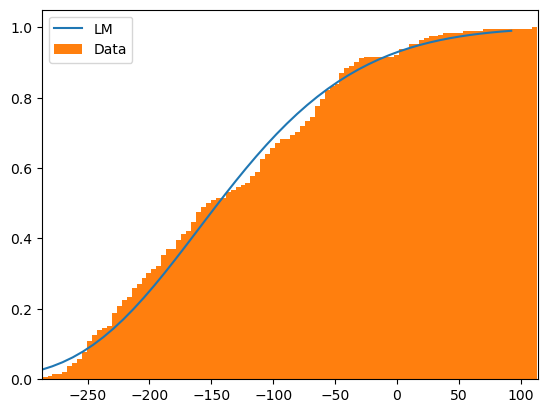

In [11]:
plt.plot(lm_ppf,lm_dist.cdf(lm_ppf),label="LM")
plt.hist(d_seq,bins=100,density=True,label="Data",cumulative=True)
plt.legend()
plt.xlim(-287,114)
#plt.ylim(0,0.1)

In [12]:
time_start=time.time()
def get_lm_paras(d_seq):
    lm_est = lm.lmom_ratios(d_seq,3)
    kappa = (0.488138*lm_est[2]**1.70839)-(1.7631*lm_est[2]**0.981824)+0.285706
    print(kappa)
    alpha = (1.023602813*lm_est[2]**1.8850974-2.95087636*lm_est[2]**1.195591244+1.759614982)*lm_est[1]
    print(alpha)
    zeta = (-0.0937*lm_est[2]**4-0.2198*lm_est[2]**3+1.407*lm_est[2]**2-1.4825*lm_est[2]-0.6205)*lm_est[1]+lm_est[0]
    print(zeta)
    return [kappa,zeta,alpha]

lm_para=get_lm_paras(d_seq)
time_end=time.time()
print('totally cost',time_end-time_start)

0.15290487059347815
80.57746410978937
-173.06582407576286
totally cost 0.0010590553283691406


In [13]:
def samlmusmall(x, nmom=5):
    try:
        x = np.asarray(x, dtype=np.float64)
        n = x.shape[0]
        x.sort(axis=0)
    except ValueError:
        raise ValueError("Input data to estimate L-moments must be numeric.")

    if nmom <= 0 or nmom > 5:
        raise ValueError("Invalid number of sample L-moments")

    if n < nmom:
        raise ValueError("Insufficient length of data for specified nmoments")

    # First L-moment

    l1 = np.sum(x,axis=0) / sp.special.comb(n, 1, exact=True)

    if nmom == 1:
        return l1

    # Second L-moment

    comb1 = range(n)
    coefl2 = 0.5 / sp.special.comb(n, 2, exact=True)
    sum_xtrans = sum([(comb1[i] - comb1[n - i - 1]) * x[i] for i in range(n)])
    l2 = coefl2 * sum_xtrans

    if nmom == 2:
        return [l1, l2]

    # Third L-moment

    comb3 = [sp.special.comb(i, 2, exact=True) for i in range(n)]
    coefl3 = 1.0 / 3.0 / sp.special.comb(n, 3, exact=True)
    sum_xtrans = sum(
        [
            (comb3[i] - 2 * comb1[i] * comb1[n - i - 1] + comb3[n - i - 1]) * x[i]
            for i in range(n)
        ]
    )
    l3 = coefl3 * sum_xtrans / l2

    if nmom == 3:
        return [l1, l2, l3]

    # Fourth L-moment

    comb5 = [sp.special.comb(i, 3, exact=True) for i in range(n)]
    coefl4 = 0.25 / sp.special.comb(n, 4, exact=True)
    sum_xtrans = sum(
        [
            (
                comb5[i]
                - 3 * comb3[i] * comb1[n - i - 1]
                + 3 * comb1[i] * comb3[n - i - 1]
                - comb5[n - i - 1]
            )
            * x[i]
            for i in range(n)
        ]
    )
    l4 = coefl4 * sum_xtrans / l2

    if nmom == 4:
        return [l1, l2, l3, l4]

    # Fifth L-moment

    comb7 = [sp.special.comb(i, 4, exact=True) for i in range(n)]
    coefl5 = 0.2 / sp.special.comb(n, 5, exact=True)
    sum_xtrans = sum(
        [
            (
                comb7[i]
                - 4 * comb5[i] * comb1[n - i - 1]
                + 6 * comb3[i] * comb3[n - i - 1]
                - 4 * comb1[i] * comb5[n - i - 1]
                + comb7[n - i - 1]
            )
            * x[i]
            for i in range(n)
        ]
    )
    l5 = coefl5 * sum_xtrans / l2

    return [l1, l2, l3, l4, l5]

In [16]:
lm_est = samlmusmall(d_frame,3)